In [ ]:
# default_exp nn

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt


In [ ]:
#export
from knowledge_distillation.io import *

In [ ]:
from knowledge_distillation.ensemble import UnbiasedAverage
from knowledge_distillation.processing import * 

In [ ]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)

In [ ]:
# export
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Load data

In [ ]:
df = load_adult()

# Preprocessing

In [ ]:
X, y, target_names = scale_onehot(df, target='salary')

y = to_categorical(y, max(y) + 1)

X_train, X_test, y_train, y_test = split_with_seed(X, y)

# Train a simple fully connected NN

In [ ]:
# export
def create_nn(
    size_layer_1=64, 
    size_layer_2=32, 
    n_class=2, 
    activation='relu', 
    l2=0.1, 
    dropout=0, 
    learning_rate=0.01
):
    """Keras fully connected neural network."""
    nn = keras.Sequential()
    nn.add(Dense(size_layer_1, kernel_regularizer=regularizers.l2(l2)))
    nn.add(BatchNormalization())
    nn.add(Activation(activation))
    nn.add(Dropout(dropout))
    
    nn.add(Dense(size_layer_2, kernel_regularizer=regularizers.l2(l2)))
    nn.add(BatchNormalization())
    nn.add(Activation(activation))
    nn.add(Dropout(dropout))
    
    nn.add(Dense(n_class, activation='softmax'))
    
    loss = 'binary_crossentropy'
    if n_class > 2:
        loss = 'categorical_crossentropy'
    
    nn.compile(loss=loss,
               optimizer=optimizers.Adam(learning_rate=learning_rate),
               metrics=[
                   'accuracy', 
#                    tf.keras.metrics.AUC()
               ]
              )
    return nn



In [ ]:
# export

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

train_params = {
    "epochs": 50, 
    "batch_size": 256,
    "validation_split":.3,
    "size_layer_1":64,
    "size_layer_2":32,
    "n_class":2
#     "callbacks": [es, mc]
}

In [ ]:
model = KerasClassifier(
    build_fn=create_nn,
    verbose=1,
    **train_params
)

In [ ]:
history = model.fit(X_train, y_train)

Epoch 1/50
72/72 [==============================] - 1s 5ms/step - loss: 3.8399 - accuracy: 0.7566 - val_loss: 0.5891 - val_accuracy: 0.7573
Epoch 2/50
72/72 [==============================] - 0s 2ms/step - loss: 0.4370 - accuracy: 0.8359 - val_loss: 0.5477 - val_accuracy: 0.7573
Epoch 3/50
72/72 [==============================] - 0s 2ms/step - loss: 0.4152 - accuracy: 0.8399 - val_loss: 0.4883 - val_accuracy: 0.7671
Epoch 4/50
72/72 [==============================] - 0s 2ms/step - loss: 0.4144 - accuracy: 0.8344 - val_loss: 0.4927 - val_accuracy: 0.7628
Epoch 5/50
72/72 [==============================] - 0s 2ms/step - loss: 0.4036 - accuracy: 0.8391 - val_loss: 0.4275 - val_accuracy: 0.8060
Epoch 6/50
72/72 [==============================] - 0s 2ms/step - loss: 0.3835 - accuracy: 0.8428 - val_loss: 0.4103 - val_accuracy: 0.8329
Epoch 7/50
72/72 [==============================] - 0s 2ms/step - loss: 0.3943 - accuracy: 0.8384 - val_loss: 0.4050 - val_accuracy: 0.8354
Epoch 8/50
72/72 [==

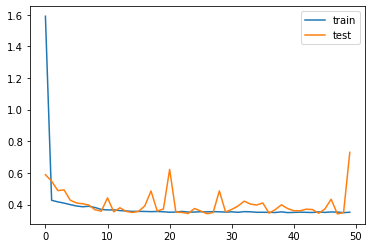

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [ ]:
model.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                6976      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0

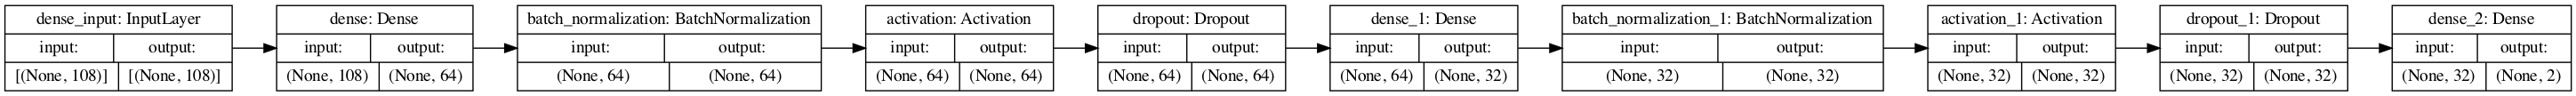

In [ ]:
keras.utils.plot_model(model.model, show_shapes=True, dpi=100, rankdir="LR")

In [ ]:
model.predict_proba(X_test.sample(5))

1/1 [==============================] - 0s 101ms/step


array([[0.7189634 , 0.28103662],
       [0.7189634 , 0.28103662],
       [0.7189634 , 0.28103662],
       [0.9983784 , 0.00162157],
       [0.7189634 , 0.28103662]], dtype=float32)

# Save model

In [ ]:
# export 

def keras_model_and_classes_paths(name, path=ASSETS_PATH):
    """Get the paths for a keras model and classes"""
    
    model_path = path / f'{name}.tf'
    classes_path = path / f'{name}_classes.pkl'
    return model_path, classes_path

def save_keras_classifier(model, name, path=ASSETS_PATH):
    """Save a Keras model to disk"""
    model_path, classes_path = keras_model_and_classes_paths(name)
    
    pickle.dump(model.classes_, open(classes_path,'wb'))
    model.model.save(model_path)


In [ ]:
save_keras_classifier(model, 'test_keras')

INFO:tensorflow:Assets written to: /Users/piazza/Playground/knowledge-distillation/nbs/../assets/test_keras.tf/assets


# Load model

In [ ]:
#export 
def do_nothing():
    return 

def load_keras_classifier(name, path=ASSETS_PATH):
    """Load a Keras model from disk, as KerasClassifier (sklearn wrapper)"""
    model_path, classes_path = keras_model_and_classes_paths(name)
    
    nn = KerasClassifier(build_fn=do_nothing)
    
    # load model and classes
    nn.model = keras.models.load_model(model_path)
    classes = pickle.load(open(classes_path, 'rb'))
    
    # required for sklearn to believe that the model is trained
    nn._estimator_type = "classifier"
    nn.classes_ = classes
    
    return nn


In [ ]:
model = load_keras_classifier(name='test_keras')

# Evaluate single model

In [ ]:
evaluate_model(X_train, X_test, y_train, y_test, model, 'nn', save_to_disk=False, target_names=target_names)

=== Train ===
              precision    recall  f1-score   support

       <=50K       0.78      1.00      0.87     19778
        >50K       0.96      0.10      0.19      6270

    accuracy                           0.78     26048
   macro avg       0.87      0.55      0.53     26048
weighted avg       0.82      0.78      0.71     26048


=== Test ===
              precision    recall  f1-score   support

       <=50K       0.78      1.00      0.87      4942
        >50K       0.96      0.09      0.17      1571

    accuracy                           0.78      6513
   macro avg       0.87      0.55      0.52      6513
weighted avg       0.82      0.78      0.70      6513




,model_name,data,accuracy,precision,recall,f1,auc
0,nn,train,0.783323,0.956268,0.104625,0.188614,0.551554
1,nn,test,0.780286,0.960526,0.092934,0.169472,0.545860


# Ensemble identical models with same random seed and average

In [ ]:
# dont_test
estimators = []

for i in range(3):
    nn = KerasClassifier(
        build_fn=create_nn,
        verbose=0,
        **train_params)

    # set the estimator_type parameter required by some sklearn functions (ie. StackingClassifier)
    nn._estimator_type = "classifier"

    estimators.append((f'test_nn_{i}', nn))

stack = StackingClassifier(
    estimators, 
    final_estimator=UnbiasedAverage(), 
    verbose=2
)

stack.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


StackingClassifier(estimators=[('test_nn_0',
                                <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f9765fb0e20>),
                               ('test_nn_1',
                                <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f9765fb0e80>),
                               ('test_nn_2',
                                <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f9765fb0f70>)],
                   final_estimator=UnbiasedAverage(), verbose=2)

In [ ]:
#dont_test
stack.predict_proba(X_test.sample(5))

array([0.09805202, 0.38804772, 0.55751234, 0.34024072, 0.2838671 ],
      dtype=float32)

In [ ]:
#dont_test
evaluate_model(X_train, X_test, y_train, y_test, stack, 'test_nn_ensemble', save_to_disk=True, target_names=target_names)

=== Train ===
              precision    recall  f1-score   support

       <=50K       0.87      0.94      0.90     19778
        >50K       0.75      0.54      0.63      6270

    accuracy                           0.85     26048
   macro avg       0.81      0.74      0.77     26048
weighted avg       0.84      0.85      0.84     26048


=== Test ===
              precision    recall  f1-score   support

       <=50K       0.87      0.94      0.90      4942
        >50K       0.75      0.55      0.64      1571

    accuracy                           0.85      6513
   macro avg       0.81      0.75      0.77      6513
weighted avg       0.84      0.85      0.84      6513




,model_name,data,accuracy,precision,recall,f1,auc
0,test_nn_ensemble,train,0.845900,0.746611,0.544657,0.629841,0.743028
1,test_nn_ensemble,test,0.847689,0.751958,0.549968,0.635294,0.746150


In [ ]:
#dont_test
for name, clf in stack.named_estimators_.items():
    evaluate_model(X_train, X_test, y_train, y_test, clf, name, save_to_disk=True, print_report=False, target_names=target_names)

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 00_io.ipynb.
Converted 01_processing.ipynb.
Converted 02_ensemble.ipynb.
Converted 03a_logistic.ipynb.
Converted 03b_NN.ipynb.
Converted 03c_bag_of_trees.ipynb.
Converted 03d_automl.ipynb.
Converted 04_train_NN.ipynb.
Converted 05_train_multiple_NNs.ipynb.
Converted 05a_test_seed_is_working.ipynb.
Converted 06_NN_ensemble.ipynb.
Converted 07_distill_multiple_NNs.ipynb.
Converted 07a_train_and_distill_multiple_NNs.ipynb.
Converted 08_compare.ipynb.
Converted XX_02_keras_native.ipynb.
Converted index.ipynb.
